In [5]:
import pandas as pd
import glob, os, re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy.io as spio
from scipy import signal
from collections import defaultdict
from datetime import datetime, timedelta
from obspy import read, Trace, UTCDateTime
import numpy.matlib
from matplotlib import cm
from scipy.io.wavfile import read as wavread
from scipy.signal import find_peaks

In [6]:
def getinfo(place, year, index):
    df = pd.read_csv('../DataBase/Experiment_period.txt')
    df_ = df[df['region']==place][df['year']==year][df['index']==index]
    S = -1*df_['h_calib'].values[0]
    begintime = pd.to_datetime(df_['begin'].values[0])
    endtime = pd.to_datetime(df_['end'].values[-1])
    # month = str(begintime.month).zfill(2)
    return begintime, endtime, S

def calib(data, S):
    return data / ((10)**(S/20))
def readwav(path, S):
    rate, data = wavread(path)
    data = data.astype(np.float32, order='C') / 32768.0
    data = calib(data, S)
    
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    date = path.rsplit('.')[1]
    tr.stats.starttime = UTCDateTime(f'20{date[:12]}')
    # print(trslice.stats.statttime)
    tr = tr.filter('bandpass', freqmin=500, freqmax=7000, corners=4, zerophase=True)
    return tr
def findpeaks(tr):

    try:
        env_tr = abs(signal.hilbert(tr.data))
        x = env_tr/np.max(env_tr)
        peaks, _ = find_peaks(x, height=0.5, distance=500)
        if len(peaks) <= 1:
            print('-'*50)
            print(tr)
            print('-'*50)
            peaks = peaks; duration = np.nan; peak_interval = np.nan
        else:
            duration = (peaks[-1]-peaks[0])/tr.stats.sampling_rate
            peak_interval = (peaks[1]-peaks[0])/tr.stats.sampling_rate
        return peaks, duration, peak_interval
    except:
        print('-'*50)
        print(tr)
        print('-'*50)
        peaks = np.nan; duration = np.nan; peak_interval = np.nan
        return peaks, duration, peak_interval
        pass


    # plt.figure(figsize=(8, 3))
    # plt.title(tr.stats.starttime)
    # plt.plot(np.arange(len(x))/tr.stats.sampling_rate, tr.data/np.max(env_tr), 'k')
    # plt.plot(np.arange(len(x))/tr.stats.sampling_rate, x, 'r', lw= 0.05)
    # plt.scatter(peaks/tr.stats.sampling_rate, x[peaks], color='b')
    

def findpeakf(tr):
    try:
        length = 256
        f,t,P = signal.stft(tr.data, fs= tr.stats.sampling_rate, window='hann', 
              nperseg=length, noverlap=int(0.9*length), nfft=48000, detrend='constant', boundary=None, padded=False)
        data = 10*np.log10(np.abs(P)/np.power(1, 2)) #+ 176.2

        axis=1
        ambient = np.percentile(data, 20, axis=axis)
        if axis==0:
            input_data = np.subtract(data, np.matlib.repmat(ambient, data.shape[axis], 1))
        elif axis==1:
            input_data = np.subtract(data, np.matlib.repmat(ambient, data.shape[axis], 1).T)    

        fidx = np.where((f>=500)&(f<=7000))

        fmin=fidx[0][0]; fmax=fidx[0][-1]
        frange = f[fmin:fmax]
        peak_f = frange[np.argmax(np.sum(input_data, axis=1)[fmin:fmax])]

        return f, t, input_data, peak_f 
    except:
        return np.nan, np.nan, np.nan, np.nan
        pass
    
def calc_SPL(tr):
    try:
        p_rms = np.sqrt(np.mean(tr.data**2))
        SPL = 20*np.log10(p_rms/1)
        return SPL
    except:
        return np.nan
    
def xcorr(tr):
    try:
        env_tr =  abs(signal.hilbert(tr.data))
        autocorr = np.correlate(env_tr, env_tr, mode='full')
        autocorr = autocorr[autocorr.size // 2:]
        tr_auto=Trace(data=autocorr)
        tr_auto.stats.sampling_rate = 96000
        tr_auto = tr_auto.detrend('linear')

        peaks, _ = find_peaks(tr_auto.data, height=np.mean(tr_auto.data)+0.45*np.std(tr_auto.data),\
                              distance=0.008*96000, prominence=0.1*10**int(np.log10(max(tr_auto.data))))

        duration = (peaks[-1]-0)/tr.stats.sampling_rate
        peak_interval = (peaks[3]-peaks[2])/tr.stats.sampling_rate   
        return peaks, duration, peak_interval, tr_auto
    except:
        return np.nan,np.nan,np.nan,np.nan

In [8]:
path = '../Results/Detection_fishcall/manual_csv_0.75/202308'
wavdir = '/Volumes/Data/Soundscape/03_TaoYuan/2023/20230818-20230902/wav'
savepath = '/Volumes/home/Research/Detect_fish/Taoyuan_fishcall'
begin, end, S = getinfo('Taoyuan', 2023, 3)

/var/folders/07/_m900g1931d1pc5dgv3v4qpw0000gn/T/ipykernel_89848/1544082423.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ = df[df['region']==place][df['year']==year][df['index']==index]


In [9]:
for day in [18,19,20,30]:
    detaildf = {'pulse':[],'pulse_interval':[],'call_duration':[], 'Peak_f':[], 'SPLrms':[], 
               'corr_pulse':[],'corr_pulse_interval':[],'corr_call_duration':[]}
    old_globwav = ''
    for csvpath in sorted(glob.glob(f'{path}/result_2308{day}.csv')):
        df = pd.read_csv(csvpath)
        print(len(df))

        for i in range(len(df)):
            keep = df['keep'].values[i]
            if keep: 
                begintmp = re.split('[(|)|,]',df['time_min_date'].values[i]); endtmp = re.split('[(|)|,]',df['time_max_date'].values[i])
                tr_begin = UTCDateTime(int(begintmp[1]),int(begintmp[2]),int(begintmp[3]),int(begintmp[4]),int(begintmp[5]),int(begintmp[6]),int(begintmp[7]))
                tr_end = UTCDateTime(int(endtmp[1]),int(endtmp[2]),int(endtmp[3]),int(endtmp[4]),int(endtmp[5]),int(endtmp[6]),int(endtmp[7]))

                globwav = glob.glob(f'{wavdir}/*{str(tr_begin.month).zfill(2)}{str(tr_begin.day).zfill(2)}{str(tr_begin.hour).zfill(2)}*')[0]
                # 
                if globwav == old_globwav:
                    # print('same wav')
                    pass
                else:
                    print('glob wav  ', globwav)
                    tr = readwav(globwav, S)

                tr_slice = tr.copy()
                tr_slice = tr_slice.slice(tr_begin, tr_end); del begintmp, endtmp
                SPL = calc_SPL(tr_slice)
                peaks, call_duration, peak_interval = findpeaks(tr_slice)
                try:
                    total_peak = len(peaks) 
                except:
                    total_peak = np.nan
                
                f, t, spect, peak_f = findpeakf(tr_slice)
                # print(peaks, call_duration, peak_interval, peak_f)

                old_globwav = globwav

                detaildf['pulse'].append(total_peak)
                detaildf['pulse_interval'].append(peak_interval)
                detaildf['call_duration'].append(call_duration)
                detaildf['Peak_f'].append(peak_f)
                detaildf['SPLrms'].append(SPL)
                
                corr_peaks, corr_duration, corr_peak_interval, tr_auto = xcorr(tr_slice)
                try:
                    detaildf['corr_pulse'].append(len(corr_peaks)+1)       
                except:
                    detaildf['corr_pulse'].append(np.nan)    
                detaildf['corr_pulse_interval'].append(corr_peak_interval)
                detaildf['corr_call_duration'].append(corr_duration)
                #----------plot
                try:
                    fig, ax = plt.subplots(3,1, figsize=(8,6), sharex=True)
                    plt.rc('font', family='Helvetica')
                    abs_env = abs(signal.hilbert(tr_slice.data))

                    ax[0].plot(tr_slice.times()*1000, abs_env,color='gray', alpha=0.5)
                    ax[0].plot(tr_slice.times()*1000, tr_slice.data,'k')
                    ax[0].scatter(peaks/96000*1000, abs_env[peaks], c='r',s=20, marker='x')
                    axf = fig.add_axes([0.92, ax[1].get_position().y0, 0.1, ax[1].get_position().y1 - ax[1].get_position().y0])
                    axf.plot(np.sum(spect,axis=1), f, 'k')
                    axf.set_ylim(500, 7000)
                    axf.set_yticklabels([])
                    ax[1].imshow(spect, vmin=6, vmax=12,
                               origin='lower',  aspect='auto', cmap=cm.jet,
                               extent=[t[0]*1000, t[-1]*1000, f[0], f[-1]], interpolation='none')
                    ax[1].set_ylabel('Frequency (Hz)', fontsize=10)
                    title = f'Pulses: {len(peaks)}, Call duration: {call_duration} s\n Pulses interval: {peak_interval} s, Peak_f: {peak_f} Hz'
                    ax[0].set_title(title, fontsize=10)
                    ax[2].set_xlabel('Time (ms)' , fontsize=10)
                    ax[1].set_ylim(500, 7000)
                    ax[1].set_xlim(tr_slice.times()[0]*1000, tr_slice.times()[-1]*1000)
                    
                    ax[2].plot(tr_auto.times()*1000, tr_auto.data, color='black')
                    ax[2].scatter(tr_auto.times()[corr_peaks]*1000, tr_auto.data[corr_peaks], color='r', s=15)
                    
                    mm = str(tr_slice.stats.starttime.month).zfill(2)
                    dd = str(tr_slice.stats.starttime.day).zfill(2)
                    hour = str(tr_slice.stats.starttime.hour).zfill(2)
                    minute = str(tr_slice.stats.starttime.minute).zfill(2)
                    second = str(tr_slice.stats.starttime.second).zfill(2)
                    if not os.path.exists(f'{savepath}/fig/23{mm}{day}'):
                        os.makedirs(f'{savepath}/fig/23{mm}{day}')
                        os.makedirs(f'{savepath}/msd/23{mm}{day}')
                    plt.savefig(f'{savepath}/fig/23{mm}{day}/23{mm}{dd}_{hour}{minute}{second}.png', dpi=200, bbox_inches='tight')
                    plt.close()
                    
                    del tr_slice, SPL,peaks, call_duration, peak_interval,f, t, spect, peak_,corr_peaks, corr_duration, corr_peak_interval, tr_auto
                    # tr_slice.write(f'{savepath}/msd/23{mm}{day}/23{mm}{dd}_{hour}{minute}{second}.mseed', format='MSEED') 
                except:
                    pass
            else:
                detaildf['pulse'].append(np.nan)
                detaildf['pulse_interval'].append(np.nan)
                detaildf['call_duration'].append(np.nan)
                detaildf['Peak_f'].append(np.nan)
                detaildf['SPLrms'].append(np.nan)
                detaildf['corr_pulse'].append(np.nan)
                detaildf['corr_pulse_interval'].append(np.nan)
                detaildf['corr_call_duration'].append(np.nan)  
            # if i % 100 ==0:
                # tmp_df = pd.concat([df, pd.DataFrame(detaildf)], axis = 1 )
                # tmp_df.to_csv(f"{path}/{re.split('[.|/]', csvpath)[-2]}_stats_begin300_{i}.csv")                
        combine_df = pd.concat([df, pd.DataFrame(detaildf)], axis = 1 )
        combine_df.to_csv(f"{path}/{re.split('[.|/]', csvpath)[-2]}_stats.csv")
print('finish')
            

2
glob wav   /Volumes/Data/Soundscape/03_TaoYuan/2023/20230818-20230902/wav/6979.230818210000.wav
glob wav   /Volumes/Data/Soundscape/03_TaoYuan/2023/20230818-20230902/wav/6979.230818220000.wav
7
glob wav   /Volumes/Data/Soundscape/03_TaoYuan/2023/20230818-20230902/wav/6979.230819210000.wav
6
glob wav   /Volumes/Data/Soundscape/03_TaoYuan/2023/20230818-20230902/wav/6979.230820220001.wav
14
glob wav   /Volumes/Data/Soundscape/03_TaoYuan/2023/20230818-20230902/wav/6979.230830200002.wav
glob wav   /Volumes/Data/Soundscape/03_TaoYuan/2023/20230818-20230902/wav/6979.230830210002.wav
finish


In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,6), sharex=True)
plt.rc('font', family='Helvetica')
abs_env = abs(signal.hilbert(tr_slice.data))

ax[0].plot(tr_slice.times()*1000, abs_env,color='gray', alpha=0.5)
ax[0].plot(tr_slice.times()*1000, tr_slice.data,'k')
ax[0].scatter(peaks/96000*1000, abs_env[peaks], c='r',s=20, marker='x')
ax[1].imshow(spect, vmin=6, vmax=12,
           origin='lower',  aspect='auto', cmap=cm.jet,
           extent=[t[0]*1000, t[-1]*1000, f[0], f[-1]], interpolation='none')
ax[1].set_ylabel('Frequency (Hz)', fontsize=10)

title = f'Pulses: {len(peaks)}, Call duration: {call_duration} s\n Pulses interval: {peak_interval} s, Peak_f: {peak_f} Hz'
ax[0].set_title(title, fontsize=10)
ax[2].set_xlabel('Time (ms)' , fontsize=10)
ax[1].set_ylim(500, 7000)
ax[1].set_xlim(tr_slice.times()[0]*1000, tr_slice.times()[-1]*1000)

ax[2].plot(tr_auto.times()*1000, tr_auto.data, color='black')
ax[2].scatter(tr_auto.times()[corr_peaks]*1000, tr_auto.data[corr_peaks], color='r', s=15)


## manual check 

In [ ]:
tr_begin = UTCDateTime('2023-06-22T21:38:45.162042Z')
tr_end = UTCDateTime('2023-06-22T21:38:45.333646Z')
globwav = glob.glob(f'{wavdir}/*062221*.wav')[0]

# print('glob wav  ', globwav)
# tr = readwav(globwav, S)

tr_slice = tr.copy()
tr_slice = tr_slice.slice(tr_begin, tr_end)

In [ ]:
tr_slice.plot()

In [ ]:


env_tr = abs(signal.hilbert(tr_slice.data))
x = env_tr/np.max(env_tr)
peaks, _ = find_peaks(x, height=0.15, distance=500)
plt.figure(figsize=(8,3))
plt.plot(x)
plt.scatter(peaks, x[peaks], c='r')
if len(peaks) <= 1:
    print('-'*50)
    print(tr)
    print('-'*50)
    peaks = peaks; duration = np.nan; peak_interval = np.nan
else:
    duration = (peaks[-1]-peaks[0])/tr_slice.stats.sampling_rate
    peak_interval = (peaks[1]-peaks[0])/tr_slice.stats.sampling_rate
    
    print(len(peaks), peak_interval, duration, )

In [ ]:
peaks, call_duration, peak_interval = findpeaks(tr_slice)
peak_f = findpeakf(tr_slice)
print(peaks, call_duration, peak_interval, peak_f)

In [ ]:
length = 256*2
f,t,P = signal.stft(tr_slice.data, fs= tr_slice.stats.sampling_rate, window='hann', 
      nperseg=length, noverlap=int(0.9*length), nfft=48000, detrend='constant', boundary=None, padded=False)
data = 10*np.log10(np.abs(P)/np.power(1, 2)) #+ 176.2

axis=1
ambient = np.percentile(data, 20, axis=axis)
if axis==0:
    input_data = np.subtract(data, np.matlib.repmat(ambient, data.shape[axis], 1))
elif axis==1:
    input_data = np.subtract(data, np.matlib.repmat(ambient, data.shape[axis], 1).T)
    
im1 = plt.imshow(input_data, vmin=6, vmax=12,
       origin='lower',  aspect='auto', cmap=cm.jet,
       extent=[t[0]*1000, t[-1]*1000, f[0], f[-1]], interpolation='none')
plt.ylim(500, 6000)

## record


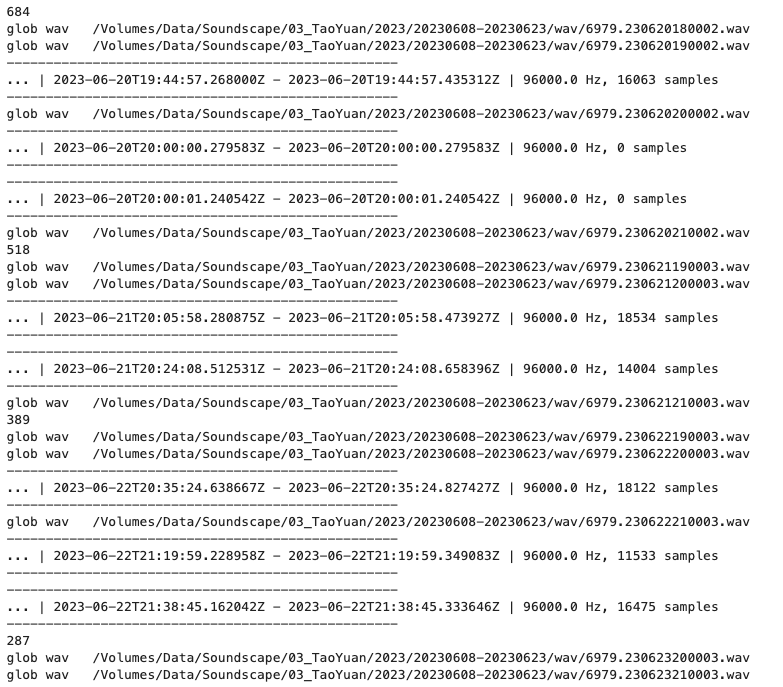

In [ ]:
from obspy import read

In [ ]:
csvpath = glob.glob(f'{path}/result_230618_stats.csv')[0]

In [ ]:
for day in [18,19,20,21,22,23]:
    for csvpath in sorted(glob.glob(f'{path}/result_2306{day}.csv')):
        trpath = glob.glob(f'{savepath}/msd/2306{day}/*.mseed')
        tr = read(trpath)[0]
        
        
        env_tr =  abs(signal.hilbert(tr.data))
        # 計算自相關
        autocorr = np.correlate(env_tr, env_tr, mode='full')
        autocorr = autocorr[autocorr.size // 2:]

        tr_auto=Trace(data=autocorr)
        tr_auto = tr_auto.detrend('linear')


        fig, ax = plt.subplots(3,1,figsize=(7, 6), sharex=True)
        ax[0].plot(tr.times()*1000, env_tr,color='gray', alpha=0.5)
        ax[0].plot(tr.times()*1000, tr.data, color='black')
        SPL = calc_SPL(tr)
        peaks, call_duration, peak_interval = findpeaks(tr)
        ax[0].scatter(peaks/96000*1000, env_tr[peaks], c='r',s=20, marker='x')
        f, t, input_data, peak_f = findpeakf(tr)
        text = f'SPL:{round(SPL,2)} dB Peaks:{len(peaks)}\nDuration: {round(call_duration*1000,2)} ms Interval: {round(peak_interval*1000,2)} ms\nPeak_frequency: {peak_f} Hz'
        ax[0].set_title(text)



        ax[1].imshow(input_data, vmin=6, vmax=12,
                   origin='lower',  aspect='auto', cmap=cm.jet,
                   extent=[t[0]*1000, t[-1]*1000, f[0], f[-1]], interpolation='none')
        ax[1].set_ylabel('Frequency (Hz)', fontsize=10)
        ax[1].set_ylim(500,7000)


        ax[2].plot(tr.times()*1000, tr_auto.data, color='black')
        x = tr_auto.data
        peaks, _ = find_peaks(x, height=np.mean(tr_auto.data)+0.4*np.std(tr_auto.data), distance=0.008*96000, prominence=0.1*10**int(np.log10(max(tr_auto.data))))
        ax[2].plot(tr.times()*1000, tr_auto.data, color='black')
        ax[2].scatter(tr.times()[peaks]*1000, tr_auto.data[peaks], color='r', s=15)
        ax[2].set_xlim(tr.times()[0]*1000,tr.times()[-1]*1000)
        duration = (peaks[-1]-0)/tr.stats.sampling_rate
        peak_interval = (peaks[3]-peaks[2])/tr.stats.sampling_rate

        text = f'{len(peaks)+1}\n{round(duration*1000,2)}\n{round(peak_interval*1000,2)}'
        ax[2].text(tr.times()[-1]*1000, max(tr_auto.data), s=text, ha='right',va='top')

        mm = str(tr.stats.starttime.month).zfill(2)
        dd = str(tr.stats.starttime.day).zfill(2)
        hour = str(tr.stats.starttime.hour).zfill(2)
        minute = str(tr.stats.starttime.minute).zfill(2)
        second = str(tr.stats.starttime.second).zfill(2)
    
    
    
    # plt.savefig(f'{savepath}/fig/23{mm}{day}/23{mm}{dd}_{hour}{minute}{second}.png', dpi=200, bbox_inches='tight')


In [ ]:
combine_df